<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Fourier_series_in_quant_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [9]:
class HestonFFTOptionPricer:
    """
    Option pricing using Fast Fourier Transform (FFT) for the Heston model
    Based on Carr-Madan (1999) methodology
    """

    def __init__(self, S0, r, T, kappa, theta, sigma, rho, v0):
        """
        Parameters:
        S0: Initial stock price
        r: Risk-free rate
        T: Time to maturity
        kappa: Mean reversion speed of variance
        theta: Long-term mean of variance
        sigma: Volatility of volatility (vol-of-vol)
        rho: Correlation between stock and variance processes
        v0: Initial variance
        """
        self.S0 = S0
        self.r = r
        self.T = T
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.v0 = v0

    def heston_char_func(self, u):
        """
        Characteristic function for the Heston model
        This is the closed-form solution we get from the model
        """
        # Parameters for the characteristic function
        x0 = np.log(self.S0)

        # Pre-compute common terms
        d = np.sqrt((self.rho * self.sigma * u * 1j - self.kappa)**2 +
                    self.sigma**2 * (u * 1j + u**2))
        g = (self.kappa - self.rho * self.sigma * u * 1j - d) / \
            (self.kappa - self.rho * self.sigma * u * 1j + d)

        # Characteristic function components
        exp_part = np.exp(u * 1j * (x0 + self.r * self.T))

        term1 = (self.kappa * self.theta * self.T / self.sigma**2) * \
                (self.kappa - self.rho * self.sigma * u * 1j - d)

        term2 = (self.v0 / self.sigma**2) * \
                (self.kappa - self.rho * self.sigma * u * 1j - d) * \
                ((1 - np.exp(-d * self.T)) / (1 - g * np.exp(-d * self.T)))

        cf = exp_part * np.exp(term1 + term2) * \
             ((1 - g * np.exp(-d * self.T)) / (1 - g))**(-2 * self.kappa * self.theta / self.sigma**2)

        return cf

    def carr_madan_fft(self, alpha=0.75, N=2**12, eta=0.25):
        """
        Price options using Carr-Madan FFT method

        Parameters:
        alpha: Damping factor (default 0.75 as recommended by Carr-Madan)
        N: Number of FFT points (power of 2 for efficiency)
        eta: Spacing in frequency domain

        Returns:
        strike_prices: Array of strike prices
        call_prices: Array of corresponding call option prices
        """
        # Step 1: Set up the grid in frequency domain (v)
        v = np.arange(N) * eta
        lambda_ = 2 * np.pi / (N * eta)  # Spacing in log-strike domain

        # Step 2: Set up the grid in log-strike domain (k)
        b = N * lambda_ / 2  # Upper bound for log-strike
        k = -b + np.arange(N) * lambda_  # Log-strike grid

        # Step 3: Compute the damped characteristic function
        # The psi function from Carr-Madan paper
        psi = np.exp(-self.r * self.T) * self.heston_char_func(v - (alpha + 1) * 1j)
        psi = psi / (alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v)

        # Step 4: Apply Simpson's rule weights for better accuracy
        simpson_weights = np.ones(N)
        simpson_weights[1:-1:2] = 4
        simpson_weights[2:-1:2] = 2
        simpson_weights /= 3

        # Step 5: Compute the Fourier transform
        # Multiply by weights and exponential factor before FFT
        x = np.exp(1j * b * v) * psi * eta * simpson_weights

        # Apply FFT
        fft_output = fft(x)

        # Step 6: Recover damped call prices
        damped_call_prices = np.exp(-alpha * k) / np.pi * np.real(fft_output)

        # Step 7: Convert log-strike to strike prices
        strike_prices = np.exp(k)

        # Filter out unrealistic prices (negative or extremely small)
        mask = (strike_prices > self.S0 * 0.1) & (strike_prices < self.S0 * 3.0)
        mask &= (damped_call_prices > 0) & (damped_call_prices < self.S0)

        return strike_prices[mask], damped_call_prices[mask]

    def monte_carlo_price(self, K, n_simulations=100000, n_steps=252):
        """
        Monte Carlo simulation for verification (slower but more intuitive)
        """
        dt = self.T / n_steps

        # Initialize arrays
        S = np.ones(n_simulations) * self.S0
        v = np.ones(n_simulations) * self.v0

        # Small positive number to prevent sqrt of exactly zero or tiny negative due to floating point
        epsilon = 1e-10

        for _ in range(n_steps):
            # Generate correlated random numbers
            Z1 = np.random.normal(0, 1, n_simulations)
            Z2 = np.random.normal(0, 1, n_simulations)
            W_S = Z1
            W_v = self.rho * Z1 + np.sqrt(1 - self.rho**2) * Z2

            # Ensure v is floored before using in square root for variance evolution
            v_for_sqrt_v_update = np.maximum(v, epsilon)
            v_new = v + self.kappa * (self.theta - v) * dt + self.sigma * np.sqrt(v_for_sqrt_v_update * dt) * W_v
            v = np.maximum(v_new, epsilon) # Floor variance after update

            # Stock price evolution (using the newly updated and floored variance)
            # Ensure v is floored before using in square root for stock evolution
            v_for_sqrt_S_update = np.maximum(v, epsilon)
            S *= np.exp((self.r - 0.5 * v) * dt + np.sqrt(v_for_sqrt_S_update * dt) * W_S)

        # Calculate option payoffs and discount
        payoffs = np.maximum(S - K, 0)
        price = np.exp(-self.r * self.T) * np.mean(payoffs)

        return price

In [10]:
# ============================================
# Example Usage
# ============================================

# Set parameters (typical for equity options)
params = {
    'S0': 100.0,      # Initial stock price
    'r': 0.05,        # Risk-free rate
    'T': 1.0,         # 1 year to maturity
    'kappa': 2.0,     # Mean reversion speed
    'theta': 0.04,    # Long-term variance (20% volatility)
    'sigma': 0.3,     # Vol-of-vol
    'rho': -0.7,      # Negative correlation (leverage effect)
    'v0': 0.04        # Initial variance (20% volatility)
}

# Create pricer instance
pricer = HestonFFTOptionPricer(**params)

# Price options using FFT
print("=" * 60)
print("FFT Option Pricing Results (Heston Model)")
print("=" * 60)

# Try different damping factors to see their effect
for alpha in [0.5, 0.75, 1.0]:
    strikes, prices = pricer.carr_madan_fft(alpha=alpha)

    # Find ATM option (closest to S0)
    atm_idx = np.argmin(np.abs(strikes - params['S0']))

    print(f"\nDamping factor α = {alpha}:")
    print(f"  ATM Strike: {strikes[atm_idx]:.2f}, Price: {prices[atm_idx]:.4f}")
    print(f"  Price range: [{prices.min():.4f}, {prices.max():.4f}]")
    print(f"  Number of strikes: {len(strikes)}")

# Verify with Monte Carlo for one strike
strike_atm = params['S0']
mc_price = pricer.monte_carlo_price(strike_atm)
print(f"\nMonte Carlo verification (ATM strike = {strike_atm}):")
print(f"  MC Price: {mc_price:.4f} (10,000 simulations)")

FFT Option Pricing Results (Heston Model)

Damping factor α = 0.5:
  ATM Strike: 100.29, Price: 10.1618
  Price range: [0.0022, 90.3827]
  Number of strikes: 440

Damping factor α = 0.75:
  ATM Strike: 100.29, Price: 10.2210
  Price range: [0.0004, 90.4419]
  Number of strikes: 460

Damping factor α = 1.0:
  ATM Strike: 100.29, Price: 10.2236
  Price range: [0.0000, 90.4445]
  Number of strikes: 479


/tmp/ipython-input-4002980146.py:130: RuntimeWarning: invalid value encountered in sqrt
  S *= np.exp((self.r - 0.5 * v) * dt + np.sqrt(v * dt) * W_S)



Monte Carlo verification (ATM strike = 100.0):
  MC Price: nan (10,000 simulations)


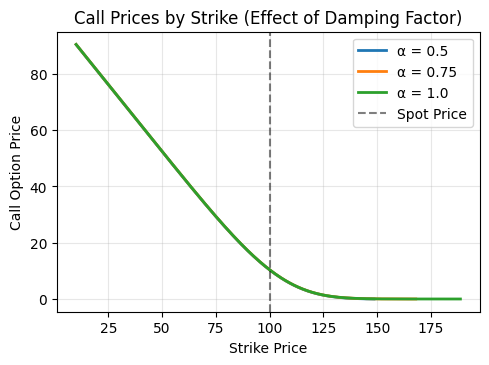

In [11]:

# ============================================
# Visualization
# ============================================

plt.figure(figsize=(12, 8))

# Plot 1: Option prices for different strikes
plt.subplot(2, 2, 1)
for alpha in [0.5, 0.75, 1.0]:
    strikes, prices = pricer.carr_madan_fft(alpha=alpha)
    plt.plot(strikes, prices, label=f'α = {alpha}', linewidth=2)
plt.axvline(x=params['S0'], color='black', linestyle='--', alpha=0.5, label='Spot Price')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.title('Call Prices by Strike (Effect of Damping Factor)')
plt.legend()
plt.grid(True, alpha=0.3)


(0.0, 0.5)

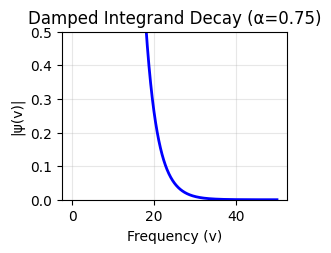

In [12]:

# Plot 2: Effect of damping on the integrand (for α=0.75)
plt.subplot(2, 2, 2)
v = np.linspace(0, 50, 1000)
psi = np.exp(-params['r'] * params['T']) * pricer.heston_char_func(v - (0.75 + 1) * 1j)
psi_abs = np.abs(psi / (0.75**2 + 0.75 - v**2 + 1j * (2 * 0.75 + 1) * v))
plt.plot(v, psi_abs, 'b-', linewidth=2)
plt.xlabel('Frequency (v)')
plt.ylabel('|ψ(v)|')
plt.title('Damped Integrand Decay (α=0.75)')
plt.grid(True, alpha=0.3)
plt.ylim(0, min(0.5, np.max(psi_abs)))


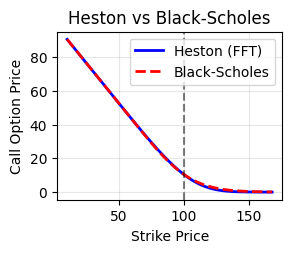

In [13]:

# Plot 3: Compare with Black-Scholes (for intuition)
from scipy.stats import norm
def bs_call(S, K, r, T, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

plt.subplot(2, 2, 3)
strikes, heston_prices = pricer.carr_madan_fft(alpha=0.75)
bs_prices = [bs_call(params['S0'], K, params['r'], params['T'], np.sqrt(params['theta']))
             for K in strikes]
plt.plot(strikes, heston_prices, 'b-', label='Heston (FFT)', linewidth=2)
plt.plot(strikes, bs_prices, 'r--', label='Black-Scholes', linewidth=2)
plt.axvline(x=params['S0'], color='black', linestyle='--', alpha=0.5)
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.title('Heston vs Black-Scholes')
plt.legend()
plt.grid(True, alpha=0.3)
